In [296]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split

In [297]:
from bml_analysis_io import *
from bml_analysis_func import *
from bml_analysis_plot import *

In [298]:
from asaplib.fit import LC_SCOREBOARD

In [299]:
def base2model(base_list, mode_list):
    return [ a+'_'+m for a in base_list for m in mode_list]

In [300]:
bmol = {}

bmol_acsf_base = [ 'acsf_longrange', 
                   'acsf_minimal', 
                   'acsf_smart']
bmol['acsf'] = base2model(base2model(bmol_acsf_base, ['ext','int']), ['rr','krr'])

bmol_cm_base = ['cm_eigenspectrum', 'cm_sorted_l2' ]
bmol['cm'] = base2model(bmol_cm_base, ['rr','krr'])


bmol_ecfp_base = ['ecfp4', 'ecfp6' ]
bmol['ecfp'] = base2model(bmol_ecfp_base, ['rr','krr'])


bmol_gylm_base = [ 'gylm_minimal', 
                   'gylm_standard']
bmol['gylm'] = base2model(base2model(bmol_gylm_base, ['ext','int']), ['rr','krr'])


bmol_mbtr_base = [ 'mbtr']
bmol['mbtr'] = base2model(base2model(bmol_mbtr_base, ['ext','int']), ['rr','krr'])


bmol_pdf_base = ['pdf_gylm_minimal', 'pdf_gylm_standard', 'pdf_soap_minimal','pdf_soap_standard']
bmol['pdf'] = base2model(bmol_pdf_base, ['rr','krr'])

bmol_physchem_base = ['physchem_basic', 'physchem_core', 'physchem_extended','physchem_logp']
bmol['physchem'] = base2model(bmol_physchem_base, ['rr','rf'])

bmol_soap_base = [ 'soap_longrange', 
                   'soap_minimal', 
                   'soap_smart']
bmol['soap'] = base2model(base2model(base2model(bmol_soap_base,['cross','nocross']), ['ext','int']), ['rr','krr'])

## parse

In [301]:
prefix = 'FH51'
file_prefix = 'benchmark_'+prefix

In [302]:
by_model = parse(file_prefix+'.json.gz')

In [303]:
all_model_keys = list(by_model.keys())
print(all_model_keys)

['bmol_acsf_longrange_ext_krr', 'bmol_acsf_longrange_ext_rr', 'bmol_acsf_longrange_int_krr', 'bmol_acsf_longrange_int_rr', 'bmol_acsf_minimal_ext_krr', 'bmol_acsf_minimal_ext_rr', 'bmol_acsf_minimal_int_krr', 'bmol_acsf_minimal_int_rr', 'bmol_acsf_smart_ext_krr', 'bmol_acsf_smart_ext_rr', 'bmol_acsf_smart_int_krr', 'bmol_acsf_smart_int_rr', 'bmol_cm_eigenspectrum_krr', 'bmol_cm_eigenspectrum_rr', 'bmol_cm_sorted_l2_krr', 'bmol_cm_sorted_l2_rr', 'bmol_ecfp4_krr', 'bmol_ecfp4_rr', 'bmol_ecfp6_krr', 'bmol_ecfp6_rr', 'bmol_gylm_minimal_ext_krr', 'bmol_gylm_minimal_ext_rr', 'bmol_gylm_minimal_int_krr', 'bmol_gylm_minimal_int_rr', 'bmol_gylm_standard_ext_krr', 'bmol_gylm_standard_ext_rr', 'bmol_gylm_standard_int_krr', 'bmol_gylm_standard_int_rr', 'bmol_mbtr_ext_krr', 'bmol_mbtr_ext_rr', 'bmol_mbtr_int_krr', 'bmol_mbtr_int_rr', 'bmol_pdf_gylm_minimal_krr', 'bmol_pdf_gylm_minimal_rr', 'bmol_pdf_gylm_standard_krr', 'bmol_pdf_gylm_standard_rr', 'bmol_pdf_soap_minimal_krr', 'bmol_pdf_soap_minimal

In [304]:
train_fraction_keys = list(by_model[all_model_keys[0]].keys())
print(train_fraction_keys)
max_train_frac = train_fraction_keys[-1]

['5:46', '10:41', '15:36', '20:31', '25:26', '30:21', '35:16', '40:11', '45:6']


## model prediction & histogram of error

__ = plot_compare_train_pred(by_model, 'bmol_soap_smart_cross_krr', True, True, 'soap_smart_cross_krr')

## analysis for individual sample

In [305]:
model_key_now = 'bmol_soap_minimal_cross_int_krr'
model_key_now_2 = 'bmol_soap_minimal_cross_int_rr'

train_fraction_key_now = train_fraction_keys[-1]
model_now = by_model[model_key_now][train_fraction_key_now]
model_now_2 = by_model[model_key_now_2][train_fraction_key_now]

{'MAE': 3.3626922273871032e-06,
 'RMSE': 3.6882884095461144e-06,
 'SUP': 9.136928667885513e-06,
 'R2': 0.9999999999999828,
 'SpearmanR': 1.0,
 'PearsonR': 0.9999999999999989}

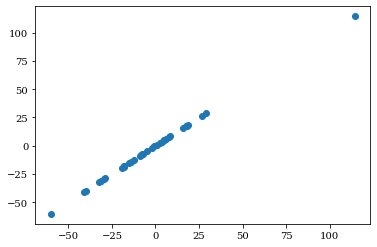

In [306]:
y_1 = model_elementwise_error(model_now,select='test',compare='MSE')
y_2 = model_elementwise_error(model_now_2,select='test',compare='MSE')

# correlations between the MAE of model 1s and model 2s
plt.scatter(y_1, y_2)
get_score(y_1, y_2)

# Combine models

In [307]:
from sklearn import linear_model

In [308]:
#clf = linear_model.Lasso(alpha=1.0,max_iter=10000, fit_intercept=False)
#clf = linear_model.LassoCV(cv=8,max_iter=10000, fit_intercept=False)

In [309]:
def fit_hybrid_lc(by_model, all_model_list, alpha=0.1, sc_name='RMSE', verbose=False):
    
    lc_scores = LC_SCOREBOARD([])
        
    clf = linear_model.Ridge(alpha,max_iter=10000, fit_intercept=False)
    
    for train_frac in by_model['bmol_soap_minimal_cross_int_krr'].keys():
        n_repeats = by_model['bmol_soap_minimal_cross_int_krr'][train_frac]['n_repeats']
        n_train = int(len(by_model['bmol_soap_minimal_cross_int_krr'][train_frac]['train'])/n_repeats)
        for replica in range(n_repeats):
            for i, model_now in enumerate(all_model_list):
                # all the original test set
                all_tmp = by_model[model_now][train_frac]['test']
                all_tmp_0 = all_tmp[all_tmp[:,-2]==replica]
                # split the set into validation and test
                n_validation = int(min(len(all_tmp_0)/2,100))   
                validation_tmp_0 , test_tmp_0 = all_tmp_0[:n_validation,:], all_tmp_0[n_validation:,:]  #train_test_split(all_tmp_0, test_size=1.-validation_ratio)
        
                if i==0:
                    hybrid_X = np.zeros((len(validation_tmp_0[:,1]),len(all_model_keys)))
                    hybrid_y = validation_tmp_0[:,2]
            
                    hybrid_X_test = np.zeros((len(test_tmp_0[:,1]),len(all_model_keys)))
                    hybrid_y_test = test_tmp_0[:,2]
            
                hybrid_X[:,i] = validation_tmp_0[:,1]
                hybrid_X_test[:,i] = test_tmp_0[:,1]
        
            clf.fit(hybrid_X, hybrid_y)
            if verbose:
                print("# replica ", replica)
            hybrid_y_pred = hybrid_y * 0.0
            hybrid_y_pred_test = hybrid_y_test * 0.0
            for i, model_now in enumerate(all_model_keys):
                if clf.coef_[i] > 0.1:
                    if verbose: print(model_now, clf.coef_[i])
                hybrid_y_pred += clf.coef_[i]*hybrid_X[:,i]
                hybrid_y_pred_test += clf.coef_[i]*hybrid_X_test[:,i]
            if verbose:
                print(get_score(hybrid_y, hybrid_y_pred))
                print(get_score(hybrid_y_test, hybrid_y_pred_test))
            lc_scores.add_score(n_train+n_validation, get_score(hybrid_y_test, hybrid_y_pred_test))
    return np.asmatrix(lc_scores.fetch(sc_name))
        

## LC

/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/numpy-1.19.0rc1-py3.7-macosx-10.9-x86_64.egg/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/numpy-1.19.0rc1-py3.7-macosx-10.9-x86_64.egg/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/scipy-1.4.1-py3.7-macosx-10.9-x86_64.egg/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/Users/tc/minicon

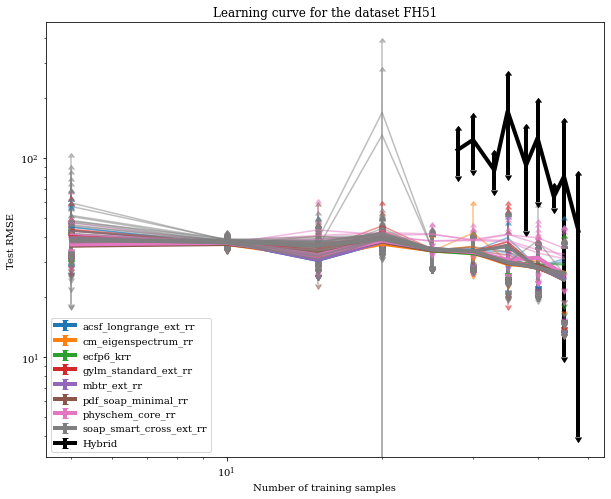

In [310]:
fig, ax = plt.subplots(figsize=(10,8))
lc_by_model = {}
lc_by_model_train = {}
sc_name='RMSE'

i=0
for category, model_key in bmol.items():
    #print(category, model_key)
    best_error = 10**20.
    best_model = None
    for key_now in model_key:
        lc_by_model[key_now], lc_by_model_train[key_now], _ = get_learning_curve(by_model, model_key_now='bmol_'+key_now, 
                                                       sc_name=sc_name)
        #ax.errorbar(lc_by_model_train[key_now][:,0], lc_by_model_train[key_now][:,1], yerr=lc_by_model_train[key_now][:,2],
        #            linestyle='--', c=cm.tab10(i), alpha=0.5,
        #            uplims=True, lolims=True)
        ax.errorbar(lc_by_model[key_now][:,0], lc_by_model[key_now][:,1], yerr=lc_by_model[key_now][:,2],
                    linestyle='-', c=cm.tab10(i), alpha=0.5,
                    uplims=True, lolims=True)
        if np.mean(lc_by_model[key_now][:,1]) < best_error:
            best_error, best_model = np.mean(lc_by_model[key_now][:,1]), key_now
    ax.errorbar(lc_by_model[best_model][:,0], lc_by_model[best_model][:,1], yerr=lc_by_model[best_model][:,2],
                linestyle='-',linewidth=4, c=cm.tab10(i), alpha=1.0, label=best_model,
                uplims=True, lolims=True)    
    i+=1

lc_hybrid = fit_hybrid_lc(by_model, all_model_keys)
ax.errorbar(lc_hybrid[:,0], lc_hybrid[:,1], yerr=lc_hybrid[:,2],
                linestyle='-',linewidth=4, c='black', alpha=1.0, label="Hybrid",
                uplims=True, lolims=True) 

ax.legend(loc='best') # bbox_to_anchor=(1.3, 0.5))
ax.set_title('Learning curve for the dataset '+prefix)
ax.set_xlabel('Number of training samples')
ax.set_ylabel('Test {}'.format(sc_name))

#plt.ylim([0.1,0.7])
ax.set_xscale('log')
ax.set_yscale('log')

fig.savefig(file_prefix+'-lc.pdf')

## model correlation matix

In [311]:
try:
    correlation_matrix = np.genfromtxt(prefix+'-model-mse.kmat')
    model_list = np.genfromtxt(prefix+'-model-mse.kmat', dtype='str')
except:
    correlation_matrix, model_list = model_correlation_matrix(by_model, max_train_frac, 'test', 'MSE', 
                                                              "PearsonR", verbose=True)
    np.savetxt(prefix+'-model-mse.kmat', correlation_matrix, fmt='%.8e')
    np.savetxt(prefix+'-model-mse.names', model_list, fmt='%s')

In [312]:
correlation_matrix_y, model_list = model_correlation_matrix(by_model, max_train_frac, 'test', 'y', 
                                                              "PearsonR", replica=4, verbose=True)

/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/numpy-1.19.0rc1-py3.7-macosx-10.9-x86_64.egg/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/numpy-1.19.0rc1-py3.7-macosx-10.9-x86_64.egg/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/scipy-1.4.1-py3.7-macosx-10.9-x86_64.egg/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/asaplib-0.0.1-py3.7.egg/asaplib/fit/getscore.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  output_scores = 1 - (numerator / denominator)
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/a

bmol_acsf_longrange_ext_rr bmol_acsf_longrange_ext_krr nan
bmol_acsf_longrange_int_krr bmol_acsf_longrange_ext_krr 0.32269364507079
bmol_acsf_longrange_int_krr bmol_acsf_longrange_ext_rr nan
bmol_acsf_longrange_int_rr bmol_acsf_longrange_ext_krr 0.32269359107039813
bmol_acsf_longrange_int_rr bmol_acsf_longrange_ext_rr nan
bmol_acsf_longrange_int_rr bmol_acsf_longrange_int_krr 0.9999999999999983
bmol_acsf_minimal_ext_krr bmol_acsf_longrange_ext_krr 0.9425797140317999
bmol_acsf_minimal_ext_krr bmol_acsf_longrange_ext_rr nan
bmol_acsf_minimal_ext_krr bmol_acsf_longrange_int_krr 0.214833676023118
bmol_acsf_minimal_ext_krr bmol_acsf_longrange_int_rr 0.21483362177553755
bmol_acsf_minimal_ext_rr bmol_acsf_longrange_ext_krr 0.9607007697162412
bmol_acsf_minimal_ext_rr bmol_acsf_longrange_ext_rr nan
bmol_acsf_minimal_ext_rr bmol_acsf_longrange_int_krr 0.19695970519511719
bmol_acsf_minimal_ext_rr bmol_acsf_longrange_int_rr 0.19695964928958382
bmol_acsf_minimal_ext_rr bmol_acsf_minimal_ext_krr 0.9

bmol_gylm_minimal_ext_rr bmol_acsf_smart_int_krr 0.8426148580915828
bmol_gylm_minimal_ext_rr bmol_acsf_smart_int_rr 0.8426148260551125
bmol_gylm_minimal_ext_rr bmol_cm_eigenspectrum_krr 0.9194374941789133
bmol_gylm_minimal_ext_rr bmol_cm_eigenspectrum_rr 0.9639935979661016
bmol_gylm_minimal_ext_rr bmol_cm_sorted_l2_krr 0.8840618194256921
bmol_gylm_minimal_ext_rr bmol_cm_sorted_l2_rr 0.8655255991745083
bmol_gylm_minimal_ext_rr bmol_ecfp4_krr 0.8426149093940984
bmol_gylm_minimal_ext_rr bmol_ecfp4_rr 0.842614904762294
bmol_gylm_minimal_ext_rr bmol_ecfp6_krr 0.8426149195846768
bmol_gylm_minimal_ext_rr bmol_ecfp6_rr 0.8426149146400175
bmol_gylm_minimal_ext_rr bmol_gylm_minimal_ext_krr 0.9999999999991326
bmol_gylm_minimal_int_krr bmol_acsf_longrange_ext_krr 0.32269359107040513
bmol_gylm_minimal_int_krr bmol_acsf_longrange_ext_rr nan
bmol_gylm_minimal_int_krr bmol_acsf_longrange_int_krr 0.9999999999999982
bmol_gylm_minimal_int_krr bmol_acsf_longrange_int_rr 1.0
bmol_gylm_minimal_int_krr bmol_

bmol_mbtr_ext_rr bmol_acsf_longrange_int_rr nan
bmol_mbtr_ext_rr bmol_acsf_minimal_ext_krr nan
bmol_mbtr_ext_rr bmol_acsf_minimal_ext_rr nan
bmol_mbtr_ext_rr bmol_acsf_minimal_int_krr nan
bmol_mbtr_ext_rr bmol_acsf_minimal_int_rr nan
bmol_mbtr_ext_rr bmol_acsf_smart_ext_krr nan
bmol_mbtr_ext_rr bmol_acsf_smart_ext_rr nan
bmol_mbtr_ext_rr bmol_acsf_smart_int_krr nan
bmol_mbtr_ext_rr bmol_acsf_smart_int_rr nan
bmol_mbtr_ext_rr bmol_cm_eigenspectrum_krr nan
bmol_mbtr_ext_rr bmol_cm_eigenspectrum_rr nan
bmol_mbtr_ext_rr bmol_cm_sorted_l2_krr nan
bmol_mbtr_ext_rr bmol_cm_sorted_l2_rr nan
bmol_mbtr_ext_rr bmol_ecfp4_krr nan
bmol_mbtr_ext_rr bmol_ecfp4_rr nan
bmol_mbtr_ext_rr bmol_ecfp6_krr nan
bmol_mbtr_ext_rr bmol_ecfp6_rr nan
bmol_mbtr_ext_rr bmol_gylm_minimal_ext_krr nan
bmol_mbtr_ext_rr bmol_gylm_minimal_ext_rr nan
bmol_mbtr_ext_rr bmol_gylm_minimal_int_krr nan
bmol_mbtr_ext_rr bmol_gylm_minimal_int_rr nan
bmol_mbtr_ext_rr bmol_gylm_standard_ext_krr nan
bmol_mbtr_ext_rr bmol_gylm_standar

bmol_pdf_gylm_minimal_rr bmol_gylm_standard_ext_rr 0.8745970218247088
bmol_pdf_gylm_minimal_rr bmol_gylm_standard_int_krr 0.9999999999999944
bmol_pdf_gylm_minimal_rr bmol_gylm_standard_int_rr 0.9999999999999944
bmol_pdf_gylm_minimal_rr bmol_mbtr_ext_krr 0.3580421575080261
bmol_pdf_gylm_minimal_rr bmol_mbtr_ext_rr nan
bmol_pdf_gylm_minimal_rr bmol_mbtr_int_krr 0.9999999999999989
bmol_pdf_gylm_minimal_rr bmol_mbtr_int_rr 0.9999999999999946
bmol_pdf_gylm_minimal_rr bmol_pdf_gylm_minimal_krr 0.9999999999999978
bmol_pdf_gylm_standard_krr bmol_acsf_longrange_ext_krr 0.32269372367304705
bmol_pdf_gylm_standard_krr bmol_acsf_longrange_ext_rr nan
bmol_pdf_gylm_standard_krr bmol_acsf_longrange_int_krr 0.9999999999999942
bmol_pdf_gylm_standard_krr bmol_acsf_longrange_int_rr 0.9999999999999873
bmol_pdf_gylm_standard_krr bmol_acsf_minimal_ext_krr 0.21483377365625578
bmol_pdf_gylm_standard_krr bmol_acsf_minimal_ext_rr 0.19695979839512892
bmol_pdf_gylm_standard_krr bmol_acsf_minimal_int_krr 0.99999999

bmol_pdf_soap_standard_krr bmol_acsf_longrange_int_krr 0.9999999999999731
bmol_pdf_soap_standard_krr bmol_acsf_longrange_int_rr 0.9999999999999587
bmol_pdf_soap_standard_krr bmol_acsf_minimal_ext_krr 0.21483387433137488
bmol_pdf_soap_standard_krr bmol_acsf_minimal_ext_rr 0.19695991782372613
bmol_pdf_soap_standard_krr bmol_acsf_minimal_int_krr 0.9999999999999696
bmol_pdf_soap_standard_krr bmol_acsf_minimal_int_rr 0.9999999999999587
bmol_pdf_soap_standard_krr bmol_acsf_smart_ext_krr 0.28386748018273217
bmol_pdf_soap_standard_krr bmol_acsf_smart_ext_rr nan
bmol_pdf_soap_standard_krr bmol_acsf_smart_int_krr 0.9999999999999731
bmol_pdf_soap_standard_krr bmol_acsf_smart_int_rr 0.9999999999999587
bmol_pdf_soap_standard_krr bmol_cm_eigenspectrum_krr 0.5722562148452811
bmol_pdf_soap_standard_krr bmol_cm_eigenspectrum_rr 0.951167658039005
bmol_pdf_soap_standard_krr bmol_cm_sorted_l2_krr 0.9497724195707982
bmol_pdf_soap_standard_krr bmol_cm_sorted_l2_rr 0.9964939773810761
bmol_pdf_soap_standard_k

bmol_physchem_basic_rr bmol_gylm_minimal_int_rr -0.5458386035280408
bmol_physchem_basic_rr bmol_gylm_standard_ext_krr -0.6188367843128658
bmol_physchem_basic_rr bmol_gylm_standard_ext_rr -0.6188367611154278
bmol_physchem_basic_rr bmol_gylm_standard_int_krr -0.5458386034625718
bmol_physchem_basic_rr bmol_gylm_standard_int_rr -0.5458386035406456
bmol_physchem_basic_rr bmol_mbtr_ext_krr -0.46834590215190236
bmol_physchem_basic_rr bmol_mbtr_ext_rr nan
bmol_physchem_basic_rr bmol_mbtr_int_krr -0.5458386165055771
bmol_physchem_basic_rr bmol_mbtr_int_rr -0.54583860346257
bmol_physchem_basic_rr bmol_pdf_gylm_minimal_krr -0.5458386367889806
bmol_physchem_basic_rr bmol_pdf_gylm_minimal_rr -0.5458386280488792
bmol_physchem_basic_rr bmol_pdf_gylm_standard_krr -0.5458386362797919
bmol_physchem_basic_rr bmol_pdf_gylm_standard_rr -0.5458386289885548
bmol_physchem_basic_rr bmol_pdf_soap_minimal_krr -0.5458388732378939
bmol_physchem_basic_rr bmol_pdf_soap_minimal_rr -0.545838780704288
bmol_physchem_bas

bmol_physchem_extended_rr bmol_acsf_minimal_ext_rr -0.028667840695812997
bmol_physchem_extended_rr bmol_acsf_minimal_int_krr -0.0647873495238123
bmol_physchem_extended_rr bmol_acsf_minimal_int_rr -0.06478736132242408
bmol_physchem_extended_rr bmol_acsf_smart_ext_krr -0.035073615195938435
bmol_physchem_extended_rr bmol_acsf_smart_ext_rr nan
bmol_physchem_extended_rr bmol_acsf_smart_int_krr -0.06478735879671761
bmol_physchem_extended_rr bmol_acsf_smart_int_rr -0.06478736132242408
bmol_physchem_extended_rr bmol_cm_eigenspectrum_krr 0.10123623331132144
bmol_physchem_extended_rr bmol_cm_eigenspectrum_rr -0.004660971802522628
bmol_physchem_extended_rr bmol_cm_sorted_l2_krr 0.10004948510367352
bmol_physchem_extended_rr bmol_cm_sorted_l2_rr 0.002144488554113786
bmol_physchem_extended_rr bmol_ecfp4_krr -0.06478719800103369
bmol_physchem_extended_rr bmol_ecfp4_rr -0.06478720218504383
bmol_physchem_extended_rr bmol_ecfp6_krr -0.06478720166331944
bmol_physchem_extended_rr bmol_ecfp6_rr -0.06478720

bmol_soap_longrange_cross_ext_krr bmol_gylm_standard_ext_rr 0.9956079200749092
bmol_soap_longrange_cross_ext_krr bmol_gylm_standard_int_krr 0.9108027371593239
bmol_soap_longrange_cross_ext_krr bmol_gylm_standard_int_rr 0.9108027372839667
bmol_soap_longrange_cross_ext_krr bmol_mbtr_ext_krr 0.6932588575376036
bmol_soap_longrange_cross_ext_krr bmol_mbtr_ext_rr nan
bmol_soap_longrange_cross_ext_krr bmol_mbtr_int_krr 0.9108027610672407
bmol_soap_longrange_cross_ext_krr bmol_mbtr_int_rr 0.9108027371593189
bmol_soap_longrange_cross_ext_krr bmol_pdf_gylm_minimal_krr 0.9108028058537508
bmol_soap_longrange_cross_ext_krr bmol_pdf_gylm_minimal_rr 0.9108027800431665
bmol_soap_longrange_cross_ext_krr bmol_pdf_gylm_standard_krr 0.9108028015636749
bmol_soap_longrange_cross_ext_krr bmol_pdf_gylm_standard_rr 0.9108027786967027
bmol_soap_longrange_cross_ext_krr bmol_pdf_soap_minimal_krr 0.9108029078347415
bmol_soap_longrange_cross_ext_krr bmol_pdf_soap_minimal_rr 0.9108028541805883
bmol_soap_longrange_cr

bmol_soap_longrange_cross_int_rr bmol_gylm_standard_int_rr 0.9999999959647353
bmol_soap_longrange_cross_int_rr bmol_mbtr_ext_krr 0.3581219556215663
bmol_soap_longrange_cross_int_rr bmol_mbtr_ext_rr nan
bmol_soap_longrange_cross_int_rr bmol_mbtr_int_krr 0.9999999959699233
bmol_soap_longrange_cross_int_rr bmol_mbtr_int_rr 0.9999999959647082
bmol_soap_longrange_cross_int_rr bmol_pdf_gylm_minimal_krr 0.999999995979659
bmol_soap_longrange_cross_int_rr bmol_pdf_gylm_minimal_rr 0.9999999959740412
bmol_soap_longrange_cross_int_rr bmol_pdf_gylm_standard_krr 0.9999999959787185
bmol_soap_longrange_cross_int_rr bmol_pdf_gylm_standard_rr 0.9999999959737437
bmol_soap_longrange_cross_int_rr bmol_pdf_soap_minimal_krr 0.9999999960015582
bmol_soap_longrange_cross_int_rr bmol_pdf_soap_minimal_rr 0.9999999959900099
bmol_soap_longrange_cross_int_rr bmol_pdf_soap_standard_krr 0.9999999959878529
bmol_soap_longrange_cross_int_rr bmol_pdf_soap_standard_rr 0.9997366136645959
bmol_soap_longrange_cross_int_rr bmo

bmol_soap_longrange_nocross_int_krr bmol_acsf_longrange_ext_krr 0.32274740766028137
bmol_soap_longrange_nocross_int_krr bmol_acsf_longrange_ext_rr nan
bmol_soap_longrange_nocross_int_krr bmol_acsf_longrange_int_krr 0.999999998024065
bmol_soap_longrange_nocross_int_krr bmol_acsf_longrange_int_rr 0.9999999980206249
bmol_soap_longrange_nocross_int_krr bmol_acsf_minimal_ext_krr 0.21489237038779807
bmol_soap_longrange_nocross_int_krr bmol_acsf_minimal_ext_rr 0.19702020101101514
bmol_soap_longrange_nocross_int_krr bmol_acsf_minimal_int_krr 0.9999999980236177
bmol_soap_longrange_nocross_int_krr bmol_acsf_minimal_int_rr 0.9999999980206249
bmol_soap_longrange_nocross_int_krr bmol_acsf_smart_ext_krr 0.28392405464541365
bmol_soap_longrange_nocross_int_krr bmol_acsf_smart_ext_rr nan
bmol_soap_longrange_nocross_int_krr bmol_acsf_smart_int_krr 0.9999999980242817
bmol_soap_longrange_nocross_int_krr bmol_acsf_smart_int_rr 0.9999999980206249
bmol_soap_longrange_nocross_int_krr bmol_cm_eigenspectrum_krr

bmol_soap_minimal_cross_ext_rr bmol_ecfp6_rr 0.8666617675798001
bmol_soap_minimal_cross_ext_rr bmol_gylm_minimal_ext_krr 0.9978200081834151
bmol_soap_minimal_cross_ext_rr bmol_gylm_minimal_ext_rr 0.9978200762648402
bmol_soap_minimal_cross_ext_rr bmol_gylm_minimal_int_krr 0.8666616820417457
bmol_soap_minimal_cross_ext_rr bmol_gylm_minimal_int_rr 0.8666616821731049
bmol_soap_minimal_cross_ext_rr bmol_gylm_standard_ext_krr 0.9976303434584056
bmol_soap_minimal_cross_ext_rr bmol_gylm_standard_ext_rr 0.9976303296622062
bmol_soap_minimal_cross_ext_rr bmol_gylm_standard_int_krr 0.8666616820417474
bmol_soap_minimal_cross_ext_rr bmol_gylm_standard_int_rr 0.8666616821908142
bmol_soap_minimal_cross_ext_rr bmol_mbtr_ext_krr 0.7695654714964497
bmol_soap_minimal_cross_ext_rr bmol_mbtr_ext_rr nan
bmol_soap_minimal_cross_ext_rr bmol_mbtr_int_krr 0.8666617114803031
bmol_soap_minimal_cross_ext_rr bmol_mbtr_int_rr 0.8666616820417415
bmol_soap_minimal_cross_ext_rr bmol_pdf_gylm_minimal_krr 0.86666176503922

bmol_soap_minimal_nocross_ext_krr bmol_gylm_standard_int_krr 0.8490548896497223
bmol_soap_minimal_nocross_ext_krr bmol_gylm_standard_int_rr 0.8490548898083492
bmol_soap_minimal_nocross_ext_krr bmol_mbtr_ext_krr 0.7892527672105866
bmol_soap_minimal_nocross_ext_krr bmol_mbtr_ext_rr nan
bmol_soap_minimal_nocross_ext_krr bmol_mbtr_int_krr 0.8490549208503064
bmol_soap_minimal_nocross_ext_krr bmol_mbtr_int_rr 0.849054889649716
bmol_soap_minimal_nocross_ext_krr bmol_pdf_gylm_minimal_krr 0.8490549778549269
bmol_soap_minimal_nocross_ext_krr bmol_pdf_gylm_minimal_rr 0.8490549453257016
bmol_soap_minimal_nocross_ext_krr bmol_pdf_gylm_standard_krr 0.8490549714683504
bmol_soap_minimal_nocross_ext_krr bmol_pdf_gylm_standard_rr 0.8490549432120837
bmol_soap_minimal_nocross_ext_krr bmol_pdf_soap_minimal_krr 0.8490551054143095
bmol_soap_minimal_nocross_ext_krr bmol_pdf_soap_minimal_rr 0.8490550397909477
bmol_soap_minimal_nocross_ext_krr bmol_pdf_soap_standard_krr 0.8490550286622321
bmol_soap_minimal_nocr

bmol_soap_minimal_nocross_int_krr bmol_soap_minimal_cross_ext_krr 0.8663075962079761
bmol_soap_minimal_nocross_int_krr bmol_soap_minimal_cross_ext_rr 0.8666617248528558
bmol_soap_minimal_nocross_int_krr bmol_soap_minimal_cross_int_krr 0.9999999999999991
bmol_soap_minimal_nocross_int_krr bmol_soap_minimal_cross_int_rr 0.9999999999999991
bmol_soap_minimal_nocross_int_krr bmol_soap_minimal_nocross_ext_krr 0.8490549350536962
bmol_soap_minimal_nocross_int_krr bmol_soap_minimal_nocross_ext_rr 0.8493108648419054
bmol_soap_minimal_nocross_int_rr bmol_acsf_longrange_ext_krr 0.322693666821733
bmol_soap_minimal_nocross_int_rr bmol_acsf_longrange_ext_rr nan
bmol_soap_minimal_nocross_int_rr bmol_acsf_longrange_int_krr 0.9999999999999993
bmol_soap_minimal_nocross_int_rr bmol_acsf_longrange_int_rr 0.9999999999999964
bmol_soap_minimal_nocross_int_rr bmol_acsf_minimal_ext_krr 0.2148337047629834
bmol_soap_minimal_nocross_int_rr bmol_acsf_minimal_ext_rr 0.1969597312936603
bmol_soap_minimal_nocross_int_rr

bmol_soap_smart_cross_ext_rr bmol_pdf_soap_standard_krr 0.8987101513871252
bmol_soap_smart_cross_ext_rr bmol_pdf_soap_standard_rr 0.9078680226012134
bmol_soap_smart_cross_ext_rr bmol_physchem_basic_rf -0.5590584186359516
bmol_soap_smart_cross_ext_rr bmol_physchem_basic_rr -0.6597402598701946
bmol_soap_smart_cross_ext_rr bmol_physchem_core_rf -0.5800219304328559
bmol_soap_smart_cross_ext_rr bmol_physchem_core_rr -0.5593819914501644
bmol_soap_smart_cross_ext_rr bmol_physchem_extended_rf 0.06170739823139944
bmol_soap_smart_cross_ext_rr bmol_physchem_extended_rr -0.06378083169372699
bmol_soap_smart_cross_ext_rr bmol_physchem_logp_rf -0.06164621175184791
bmol_soap_smart_cross_ext_rr bmol_physchem_logp_rr -0.5243473294629429
bmol_soap_smart_cross_ext_rr bmol_soap_longrange_cross_ext_krr 0.9981519152814664
bmol_soap_smart_cross_ext_rr bmol_soap_longrange_cross_ext_rr 0.9942728027192501
bmol_soap_smart_cross_ext_rr bmol_soap_longrange_cross_int_krr 0.8987489899139782
bmol_soap_smart_cross_ext_

bmol_soap_smart_cross_int_rr bmol_pdf_gylm_standard_rr 0.9999999999598885
bmol_soap_smart_cross_int_rr bmol_pdf_soap_minimal_krr 0.9999999999627663
bmol_soap_smart_cross_int_rr bmol_pdf_soap_minimal_rr 0.999999999961609
bmol_soap_smart_cross_int_rr bmol_pdf_soap_standard_krr 0.9999999999613722
bmol_soap_smart_cross_int_rr bmol_pdf_soap_standard_rr 0.9997349948661867
bmol_soap_smart_cross_int_rr bmol_physchem_basic_rf -0.7993122072741243
bmol_soap_smart_cross_int_rr bmol_physchem_basic_rr -0.5458418759380654
bmol_soap_smart_cross_int_rr bmol_physchem_core_rf -0.7931790670199197
bmol_soap_smart_cross_int_rr bmol_physchem_core_rr -0.7960307377303659
bmol_soap_smart_cross_int_rr bmol_physchem_extended_rf -0.22715851423508612
bmol_soap_smart_cross_int_rr bmol_physchem_extended_rr -0.06478705101512923
bmol_soap_smart_cross_int_rr bmol_physchem_logp_rf -0.4074219482943039
bmol_soap_smart_cross_int_rr bmol_physchem_logp_rr -0.74782540801283
bmol_soap_smart_cross_int_rr bmol_soap_longrange_cros

bmol_soap_smart_nocross_ext_rr bmol_soap_longrange_nocross_ext_rr 0.9880283392647509
bmol_soap_smart_nocross_ext_rr bmol_soap_longrange_nocross_int_krr 0.8588643169550516
bmol_soap_smart_nocross_ext_rr bmol_soap_longrange_nocross_int_rr 0.8588643544637946
bmol_soap_smart_nocross_ext_rr bmol_soap_minimal_cross_ext_krr 0.9922398184051269
bmol_soap_smart_nocross_ext_rr bmol_soap_minimal_cross_ext_rr 0.9922307557040723
bmol_soap_smart_nocross_ext_rr bmol_soap_minimal_cross_int_krr 0.858832461443447
bmol_soap_smart_nocross_ext_rr bmol_soap_minimal_cross_int_rr 0.858832461443517
bmol_soap_smart_nocross_ext_rr bmol_soap_minimal_nocross_ext_krr 0.9933277874966321
bmol_soap_smart_nocross_ext_rr bmol_soap_minimal_nocross_ext_rr 0.993337017745484
bmol_soap_smart_nocross_ext_rr bmol_soap_minimal_nocross_int_krr 0.8588324420507514
bmol_soap_smart_nocross_ext_rr bmol_soap_minimal_nocross_int_rr 0.8588324420507782
bmol_soap_smart_nocross_ext_rr bmol_soap_smart_cross_ext_krr 0.9971302212186905
bmol_so

bmol_soap_smart_nocross_int_rr bmol_soap_smart_cross_int_rr 0.9999999999979703
bmol_soap_smart_nocross_int_rr bmol_soap_smart_nocross_ext_krr 0.8546504316219923
bmol_soap_smart_nocross_int_rr bmol_soap_smart_nocross_ext_rr 0.8588360176265034
bmol_soap_smart_nocross_int_rr bmol_soap_smart_nocross_int_krr 1.0


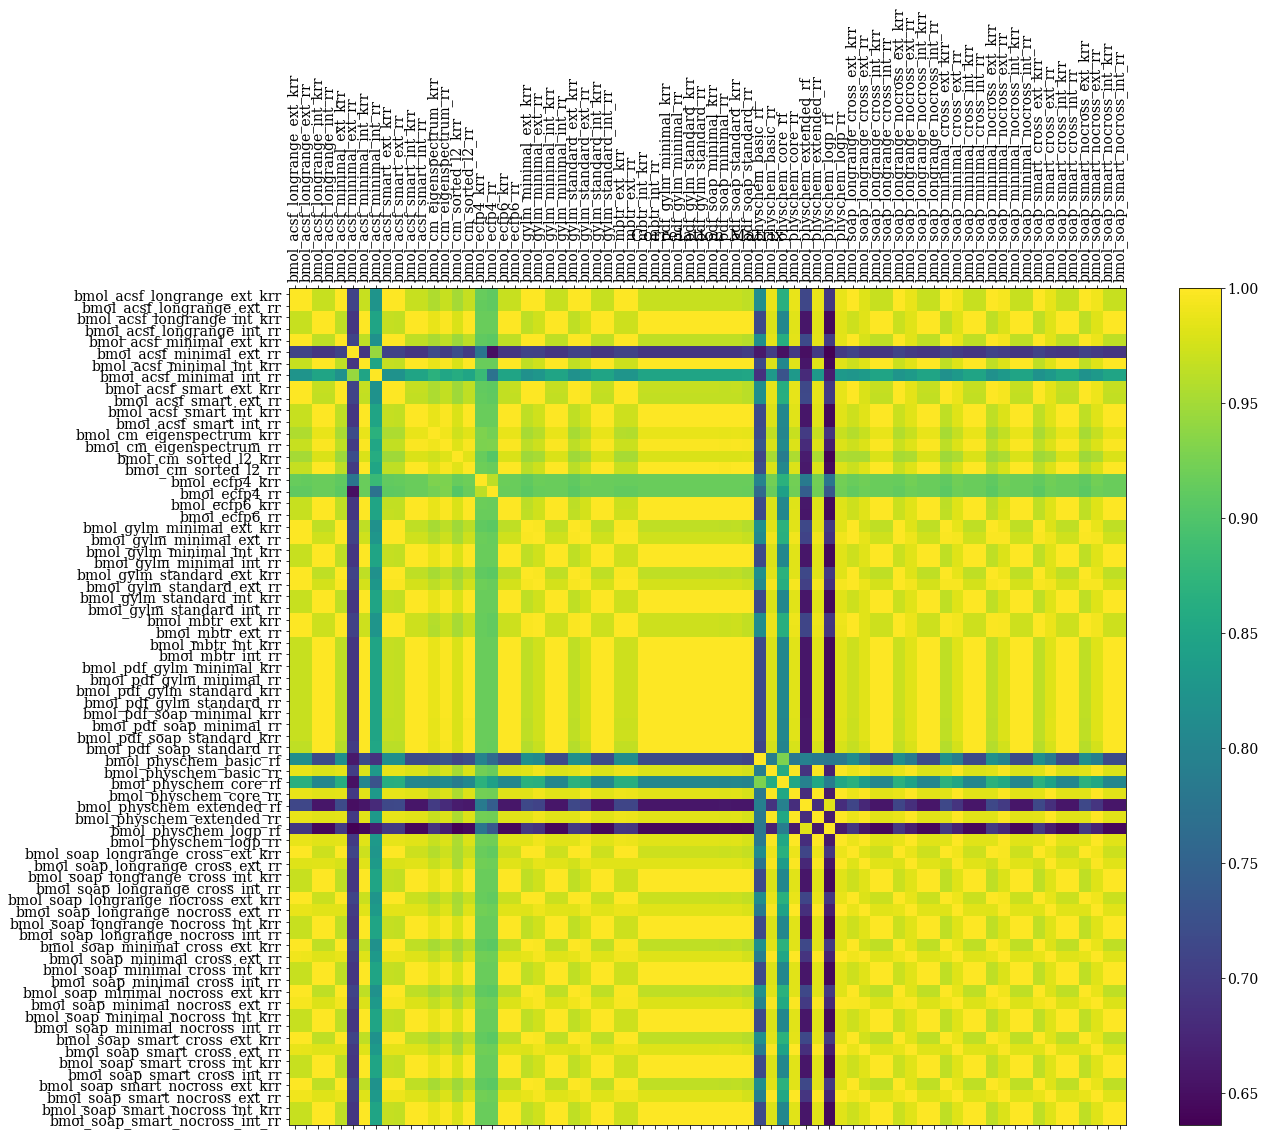

In [313]:
f = plt.figure(figsize=(19, 15))
plt.matshow(correlation_matrix, fignum=f.number)
plt.xticks(range(correlation_matrix.shape[1]), by_model.keys(), fontsize=14, rotation=90)
plt.yticks(range(correlation_matrix.shape[1]), by_model.keys(), fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## KPCA this correlation matrix

In [314]:
from asaplib.reducedim import Dimension_Reducers

reduce_dict = {}
reduce_dict['kpca'] = {"type": 'SPARSE_KPCA',
                        'parameter':{"n_components": 10,
                                     "n_sparse": -1, # no sparsification
                                "kernel": {"first_kernel": {"type": 'linear'}}}}
dreducer = Dimension_Reducers(reduce_dict)

Using kernel PCA (sparsified) ...


In [315]:
proj = dreducer.fit_transform(np.abs(correlation_matrix))

Not using any sparsification


# Visualizations

In [316]:
from asaplib.plot import Plotters

Using scatter plot ...
Using annotation plot ...


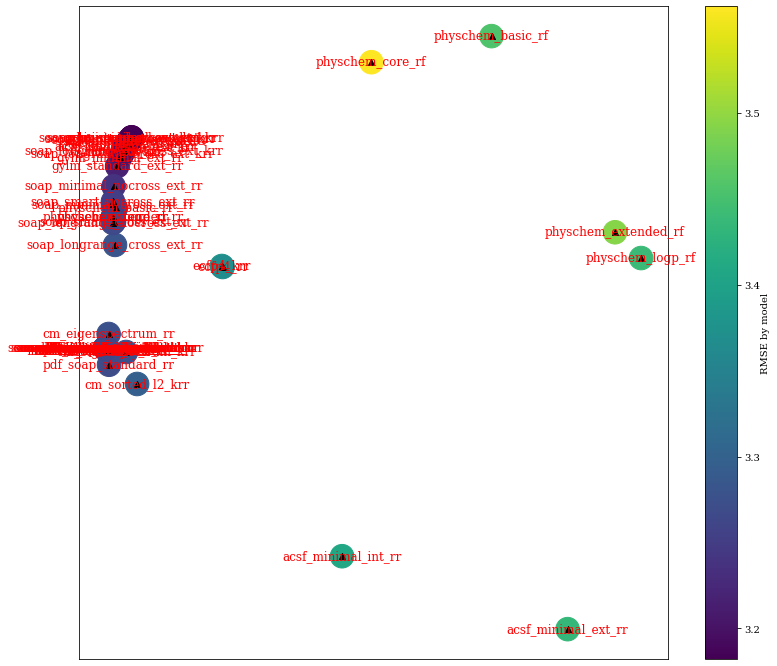

In [317]:
fig_spec = { 'outfile': file_prefix+'-model-kpca.pdf',
                'show': False,
                'title': None,
                'size': [12*1.1, 12],
                'xlabel': None, 'ylabel': None,
                            'xaxis': False, 'yaxis': False,
                            'remove_tick': True,
                'cmap': 'viridis',
                    'components':{
                    'first_p': {'type': 'scatter', 'clabel': 'RMSE by model',
                                'vmin':None, 'vmax': None},
                    'second_p': {"type": 'annotate', 'adtext': False} 
                    }
                   }
    
asap_plot = Plotters(fig_spec)

plotcolor = [ np.log(lc_by_model[k[5:]][-1,1]) for k in by_model.keys()]
annotate = list([ x[5:] for x in by_model.keys()])
asap_plot.plot(proj[:, [0,1]], plotcolor, [], annotate)
#fig.savefig(file_prefix+'-model-kpca.pdf')

## compare all models (with diff train ratios)

# kernel matrix of descriptors

In [318]:
# note that we clip the min
desc_kmat = np.clip(np.loadtxt(prefix+"-descriptors-spearman.kmat"),0,1)
#desc_kmat = desc_kmat+np.ones(np.shape(desc_kmat))
desc_names = np.genfromtxt(prefix+"-descriptors.names", dtype='str')

In [319]:
print(desc_names)

['bmol_acsf_minimal_int_krr' 'bmol_acsf_minimal_ext_krr'
 'bmol_acsf_smart_int_krr' 'bmol_acsf_smart_ext_krr'
 'bmol_acsf_longrange_int_krr' 'bmol_acsf_longrange_ext_krr'
 'bmol_cm_sorted_l2_krr' 'bmol_cm_eigenspectrum_krr' 'bmol_ecfp4_krr'
 'bmol_ecfp6_krr' 'bmol_gylm_minimal_int_krr' 'bmol_gylm_standard_int_krr'
 'bmol_gylm_minimal_ext_krr' 'bmol_gylm_standard_ext_krr'
 'bmol_mbtr_int_krr' 'bmol_mbtr_ext_krr' 'bmol_pdf_soap_standard_krr'
 'bmol_pdf_gylm_standard_krr' 'bmol_pdf_soap_minimal_krr'
 'bmol_pdf_gylm_minimal_krr' 'bmol_soap_minimal_nocross_int_krr'
 'bmol_soap_minimal_cross_int_krr' 'bmol_soap_smart_nocross_int_krr'
 'bmol_soap_smart_cross_int_krr' 'bmol_soap_longrange_nocross_int_krr'
 'bmol_soap_longrange_cross_int_krr' 'bmol_soap_minimal_nocross_ext_krr'
 'bmol_soap_minimal_cross_ext_krr' 'bmol_soap_smart_nocross_ext_krr'
 'bmol_soap_smart_cross_ext_krr' 'bmol_soap_longrange_nocross_ext_krr'
 'bmol_soap_longrange_cross_ext_krr']


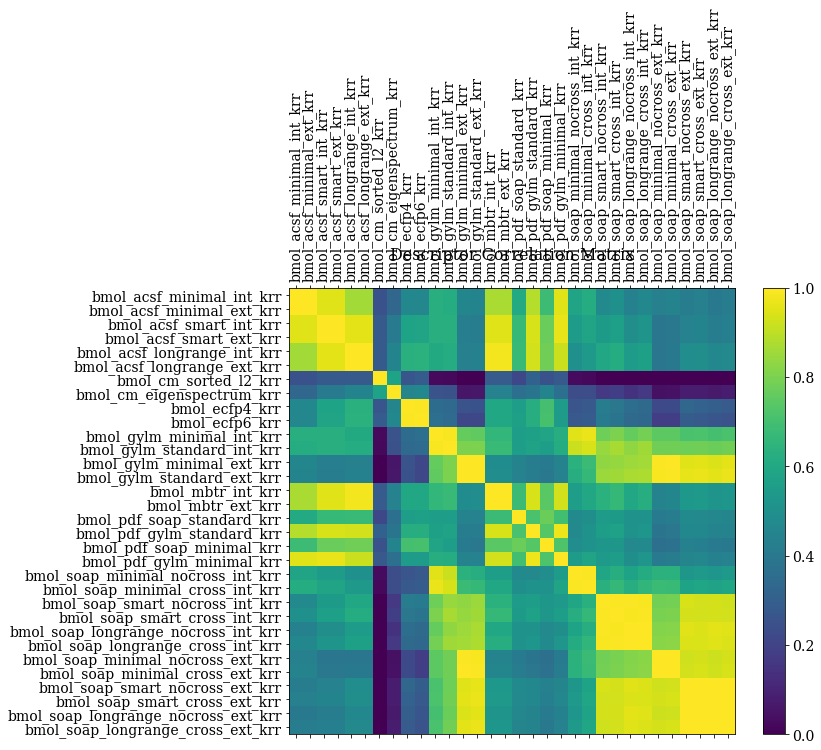

In [320]:
f = plt.figure(figsize=(10, 8))
plt.matshow(desc_kmat, fignum=f.number,vmin=None, vmax=None)
plt.xticks(range(desc_kmat.shape[1]), desc_names, fontsize=14, rotation=90)
plt.yticks(range(desc_kmat.shape[1]), desc_names, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Descriptor Correlation Matrix', fontsize=16);

In [321]:
reduce_dict2 = {}
reduce_dict2['kpca'] = {"type": 'SPARSE_KPCA',
                        'parameter':{"n_components": 10,
                                     "n_sparse": -1, # no sparsification
                                "kernel": {"first_kernel": {"type": 'cosine'}}}}

dreducer2 = Dimension_Reducers(reduce_dict2)
proj = dreducer2.fit_transform(desc_kmat)

Using kernel PCA (sparsified) ...
Not using any sparsification


Using scatter plot ...
Using annotation plot ...


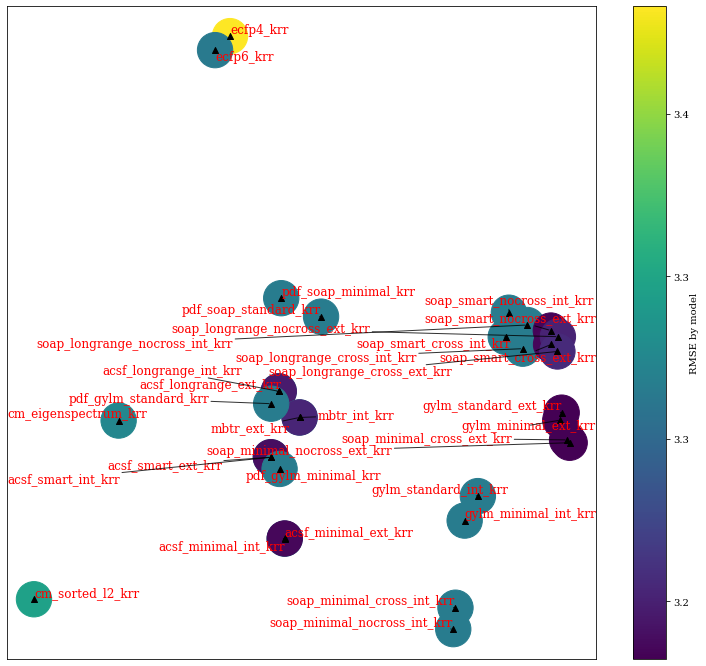

In [322]:
fig_spec = { 'outfile': file_prefix+'-descriptor-similarity.pdf',
                'show': False,
                'title': None,
                'size': [12*1.1, 12],
                'xlabel': None, 'ylabel': None,
                            'xaxis': False, 'yaxis': False,
                            'remove_tick': True,
                'cmap': 'viridis',
                    'components':{
                    'first_p': {'type': 'scatter', 'clabel': 'RMSE by model',
                                'vmin':None, 'vmax': None},
                    'second_p': {"type": 'annotate', 'adtext': True} 
                    }
                   }
    
asap_plot = Plotters(fig_spec)
plotcolor = [ lc_by_model[k[5:]][-1,1] for k in desc_names]
annotate = list([ x[5:] for x in desc_names])
#plotcolor = np.arange(len(proj))
asap_plot.plot(proj[:, [0,2]], np.log(plotcolor), [], annotate)

In [323]:
# select out certain components
sub_correlation_matrix = np.ones((len(desc_names),len(desc_names)))
sub_lc_matrix = np.ones((len(desc_names),len(desc_names),2))

for i, desc in enumerate(desc_names):
    index_now = list(by_model.keys()).index(desc)
    for j, desc2 in enumerate(desc_names):
        index_2 = list(by_model.keys()).index(desc2)
        sub_correlation_matrix[i,j] = correlation_matrix_y[index_now,index_2]
        sub_lc_matrix[i,j] = [ lc_by_model[desc[5:]][-1,1] , lc_by_model[desc2[5:]][-1,1]]
np.min(sub_correlation_matrix)

0.2148336217755455

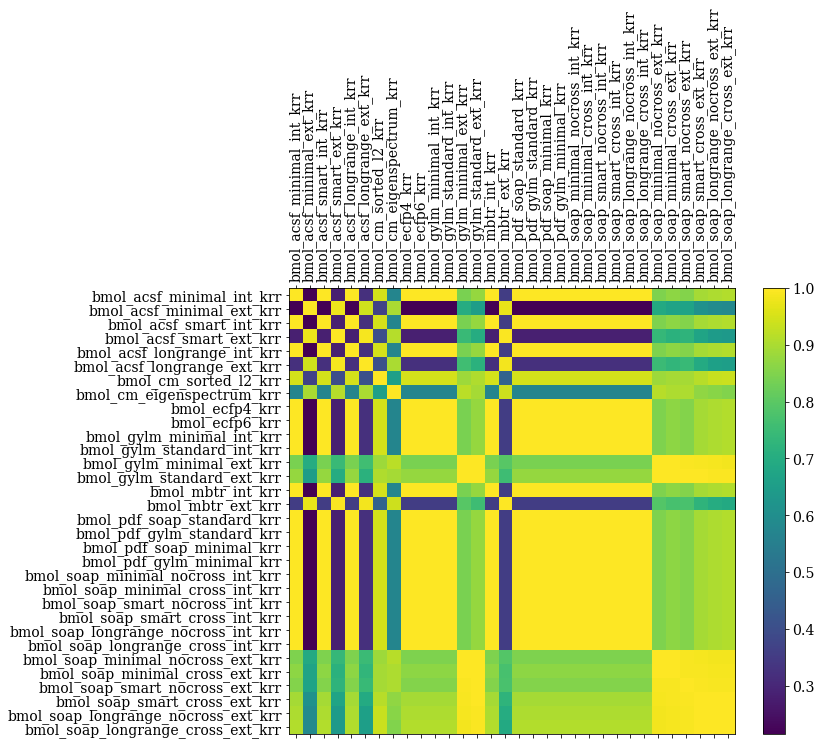

In [324]:
f = plt.figure(figsize=(10, 8))
plt.matshow(sub_correlation_matrix, fignum=f.number)
plt.xticks(range(sub_correlation_matrix.shape[1]), desc_names, fontsize=14, rotation=90)
plt.yticks(range(sub_correlation_matrix.shape[1]), desc_names, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Descriptor Correlation Matrix', fontsize=16);

In [325]:
get_score(sub_correlation_matrix[4], desc_kmat[4])

{'MAE': 0.3692350064220762,
 'RMSE': 0.41591719589402815,
 'SUP': 0.67728954592921,
 'R2': -2.7471912714537234,
 'SpearmanR': 0.33107241063244736,
 'PearsonR': -0.30379928869733275}

In [326]:
plotcolor = [ lc_by_model[k[5:]][-1,1] for k in desc_names]

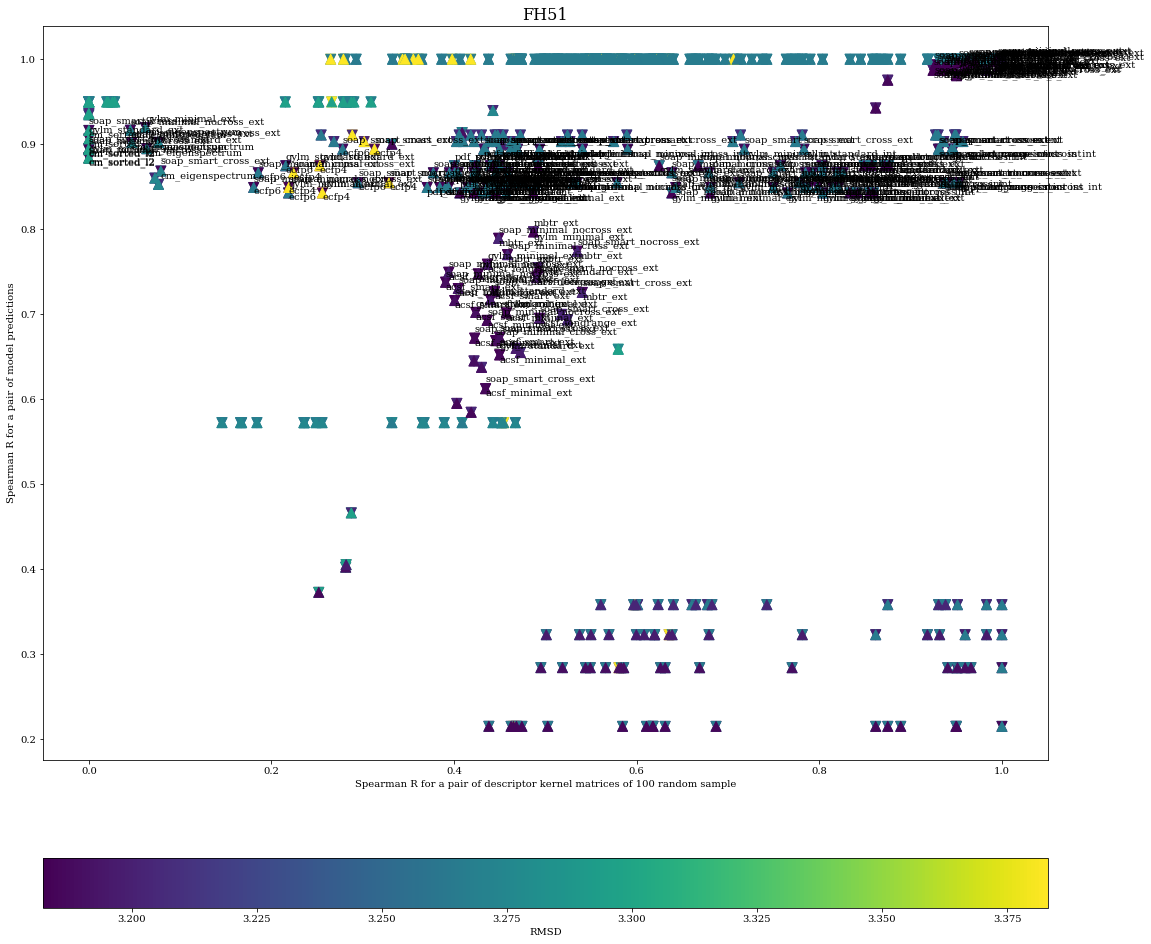

In [327]:
fig, ax = plt.subplots(figsize=(18,18))
p1 = ax.scatter(desc_kmat.flatten(),sub_correlation_matrix.flatten(), 
            marker='v', s=100, c=np.log(sub_lc_matrix[:,:,0].flatten()))
ax.scatter(desc_kmat.flatten(),sub_correlation_matrix.flatten(), 
            marker='^', s=100, c=np.log(sub_lc_matrix[:,:,1].flatten()))

cbar = fig.colorbar(p1, orientation="horizontal", pad=0.1)
cbar.set_label('RMSD')

desc_ex_best = []

ylimit=[np.min(sub_correlation_matrix),1]
offset = min((np.max(sub_correlation_matrix)-np.min(sub_correlation_matrix))/100., (ylimit[1]-ylimit[0])/100.,)
error_limit = np.percentile(sub_lc_matrix, 20)

for i, desc in enumerate(desc_names):
    for j, desc2 in enumerate(desc_names):
        if i>j and (sub_lc_matrix[i,j,0]<error_limit or sub_lc_matrix[i,j,1]<error_limit): # and desc[-7:-4] != 'ext' and desc2[-7:-4] != 'ext':
            desc_ex_best.append([desc_kmat[i,j],sub_correlation_matrix[i,j]])
            ax.annotate(desc[5:-4],(desc_kmat[i,j],sub_correlation_matrix[i,j]),
                        xytext = (desc_kmat[i,j], offset+sub_correlation_matrix[i,j]))
            ax.annotate(desc2[5:-4],(desc_kmat[i,j],sub_correlation_matrix[i,j]), 
                        xytext = (desc_kmat[i,j], -offset+sub_correlation_matrix[i,j]))
#plt.ylim(ylimit)
ax.set_xlabel("Spearman R for a pair of descriptor kernel matrices of 100 random sample")
ax.set_ylabel("Spearman R for a pair of model predictions")
ax.set_title(prefix, fontsize=16);

plt.savefig(prefix+'-corr-desc-model.pdf')

In [328]:
get_score(sub_correlation_matrix.flatten(), desc_kmat.flatten())

{'MAE': 0.3403922466811339,
 'RMSE': 0.4143872307036494,
 'SUP': 0.9497874575816332,
 'R2': -1.538717725958207,
 'SpearmanR': 0.2249857907691062,
 'PearsonR': 0.019216947993557727}

In [329]:
get_score(np.array(np.matrix(desc_ex_best)[:,0].flatten())[0],
          np.array(np.matrix(desc_ex_best)[:,1].flatten())[0])

{'MAE': 0.2951523859413499,
 'RMSE': 0.3830968863843836,
 'SUP': 0.9162107481889307,
 'R2': -23.107219785312765,
 'SpearmanR': 0.36526686354045906,
 'PearsonR': 0.43548444630391797}

In [330]:
select_models = []
invRMSE = np.asarray([ np.array([i, 1./lc_by_model[k[5:]][-1,1]]) for i, k in enumerate(desc_names)])
for step in range(4):
    sortedinvRMSE = invRMSE[invRMSE[:,1].argsort()][::-1]
    select = [ int(sortedinvRMSE[0,0]),sortedinvRMSE[0,1] ]
    invRMSE[select[0],1] = 0.0
    #symselected[step] = int(sortedinvRMSE[0,0])
    print(select, desc_names[select[0]])
    select_models.append( desc_names[select[0]])
    for index in range(len(desc_names)):
        invRMSE[index,1] *= (1.-abs(desc_kmat[select[0],index]))

[13, 0.04148800995092393] bmol_gylm_standard_ext_krr
[6, 0.03702015932494427] bmol_cm_sorted_l2_krr
[9, 0.02128739106776021] bmol_ecfp6_krr
[20, 0.010005687937729175] bmol_soap_minimal_nocross_int_krr


/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/numpy-1.19.0rc1-py3.7-macosx-10.9-x86_64.egg/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/numpy-1.19.0rc1-py3.7-macosx-10.9-x86_64.egg/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/scipy-1.4.1-py3.7-macosx-10.9-x86_64.egg/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/Users/tc/minicon

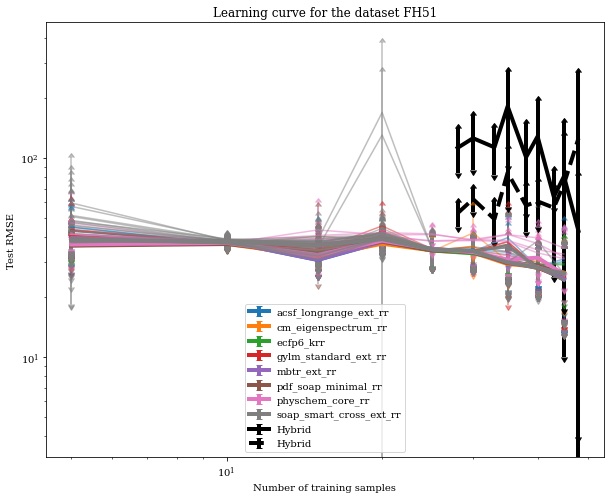

In [331]:
fig, ax = plt.subplots(figsize=(10,8))
lc_by_model = {}
lc_by_model_train = {}
sc_name='RMSE'

i=0
for category, model_key in bmol.items():
    #print(category, model_key)
    best_error = 10**20.
    best_model = None
    for key_now in model_key:
        lc_by_model[key_now], lc_by_model_train[key_now], _ = get_learning_curve(by_model, model_key_now='bmol_'+key_now, 
                                                       sc_name=sc_name)
        #ax.errorbar(lc_by_model_train[key_now][:,0], lc_by_model_train[key_now][:,1], yerr=lc_by_model_train[key_now][:,2],
        #            linestyle='--', c=cm.tab10(i), alpha=0.5,
        #            uplims=True, lolims=True)
        ax.errorbar(lc_by_model[key_now][:,0], lc_by_model[key_now][:,1], yerr=lc_by_model[key_now][:,2],
                    linestyle='-', c=cm.tab10(i), alpha=0.5,
                    uplims=True, lolims=True)
        if np.mean(lc_by_model[key_now][:,1]) < best_error:
            best_error, best_model = np.mean(lc_by_model[key_now][:,1]), key_now
    ax.errorbar(lc_by_model[best_model][:,0], lc_by_model[best_model][:,1], yerr=lc_by_model[best_model][:,2],
                linestyle='-',linewidth=4, c=cm.tab10(i), alpha=1.0, label=best_model,
                uplims=True, lolims=True)    
    i+=1

lc_hybrid = fit_hybrid_lc(by_model, all_model_keys, alpha=0.001)
ax.errorbar(lc_hybrid[:,0], lc_hybrid[:,1], yerr=lc_hybrid[:,2],
                linestyle='-',linewidth=4, c='black', alpha=1.0, label="Hybrid",
                uplims=True, lolims=True) 

lc_hybrid = fit_hybrid_lc(by_model, select_models, alpha=0.001)
ax.errorbar(lc_hybrid[:,0], lc_hybrid[:,1], yerr=lc_hybrid[:,2],
                linestyle='--',linewidth=4, c='black', alpha=1.0, label="Hybrid",
                uplims=True, lolims=True) 

ax.legend(loc='best') # bbox_to_anchor=(1.3, 0.5))
ax.set_title('Learning curve for the dataset '+prefix)
ax.set_xlabel('Number of training samples')
ax.set_ylabel('Test {}'.format(sc_name))

#plt.ylim([0.1,0.7])
ax.set_xscale('log')
ax.set_yscale('log')

fig.savefig(file_prefix+'-lc.pdf')